In [1]:
# Общие библиотеки
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
import json
from math import sin, cos

# Для создания и обучения модели
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms

# Для работы с изображениями
import cv2
from PIL import Image

# Для визуализации
import matplotlib.pyplot as plt
from IPython.display import clear_output

Преобразование начального датасета

На данном этапе данные, хранящиеся в json файлах, преобразовываются в pandas-датафрейм.



In [2]:
%%time
json_dir = "content/train/json/"

data_df = pd.DataFrame({'id': [], "left_top_x": [], 'left_top_y': [], "right_bottom_x": [], 'right_bottom_y': [], 'angle': []})

json_true = []
for _, _, files in os.walk(json_dir):
    for x in files:
        if x.endswith(".json"):
            data = json.load(open(json_dir + x))
            new_row = {'id':x.split(".")[0]+".png", 'left_top_x':data["left_top"][0], 'left_top_y':data["left_top"][1], 'right_bottom_x': data["right_bottom"][0], "right_bottom_y": data["right_bottom"][1], 'angle': data["angle"]}
            data_df = data_df.append(new_row, ignore_index=True)

data_df.head(5)

Wall time: 5.4 s


,id,left_top_x,left_top_y,right_bottom_x,right_bottom_y,angle
0,1.png,8533.0,2184.0,9834.0,2819.0,341.0
1,100.png,7078.0,4789.0,7597.0,3438.0,246.0
2,1000.png,6291.0,8856.0,6090.0,10291.0,53.0
3,1003.png,5970.0,7996.0,5719.0,6569.0,215.0
4,1004.png,4953.0,8885.0,6046.0,9836.0,356.0


Загрузчик данных

Сначала напишем класс, в котором данные непосредственно загружаются и приводятся в нужный формат.



In [3]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, labels = self.data_df.iloc[idx]['id'], [self.data_df.iloc[idx]['left_top_x']/10496, 
                                                            self.data_df.iloc[idx]['left_top_y']/10496, 
                                                            self.data_df.iloc[idx]['right_bottom_x']/10496, 
                                                            self.data_df.iloc[idx]['right_bottom_y']/10496, 
                                                            self.data_df.iloc[idx]['angle']]

        # читаем картинку. read the image
        image = cv2.imread(f"content/train/img/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(labels).float()
    
    def __len__(self):
        return len(self.data_df)

Далее зададим аугментации, которые будут использоваться при обучении модели.


In [4]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

Посмотрим на количество данных и разделим их на тренировочную и валидационную части.



In [5]:
from os import listdir

print("Обучающей выборки " ,len(listdir("content/train/img")))
print("Тестовой выборки " ,len(listdir("content/test")))

# Обучающей выборки 800
# Тестовой выборки 400

Обучающей выборки  800
Тестовой выборки  400


In [6]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=43)

Каждую из выборок подадим в ранее созданный класс. 

После чего обернем это в другой класс, уже существующий в библиотеке torch - DataLoader.



In [7]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)


In [29]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=2,
                                           shuffle=True,
                                           pin_memory=True,
                                           #num_workers=2
                                          )

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=2,
                                           # shuffle=True,
                                           pin_memory=True,
                                           #num_workers=2
                                          )


### Вспомогательные функции
Для обучения модели нам понадобятся функции расчета метрики, построения графика обучения и непосредственно обучения.

Ниже приведена функция рассчета метрики. Важное замечание - метрика для лидерборда рассчитывается исправленной метрикой, что именно исправлено можно прочитать в разделе "Метрика".



In [9]:
def compute_metric(data_true, data_pred, outImageW = 10496, outImageH = 10496):

    x_center_true = np.array((data_true[0] + data_true[2])/2).astype(int)
    y_center_true = np.array((data_true[1] + data_true[3])/2).astype(int)

    x_metr = x_center_true - np.array((data_pred[0] + data_pred[2])/2).astype(int)
    y_metr = y_center_true - np.array((data_pred[1] + data_pred[3])/2).astype(int)

    metr =  1 - 0.7 * (abs(x_metr)/outImageH + abs(y_metr)/outImageW)/2 + 0.3 *abs(data_pred[4] - data_true[4])/359
    return metr


Функция визуализации графиков обучения.



In [10]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()


Процесс обучения модели написан вручную без готовых функций (таких как TrainEpoch). Это дает более четкий контроль процесса обучения и возможность его кастомизировать.



In [11]:
def train(res_model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = []

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append((loss.data.cpu().detach().numpy() / y_pred.size(0)) * 100)
            
            y_pred[:, :4] = y_pred[:, :4] * 10496
            y_pred[:, -1] = y_pred[:, -1] * 360

            labels[:, :4] = labels[:, :4] * 10496
            labels[:, -1] = labels[:, -1] * 360

            for label, pr in zip(labels, y_pred):
                    train_pred.append(compute_metric(label.cpu().detach().numpy(), pr.cpu().detach().numpy()))

            optimizer.step()

        train_acc_log.append(train_pred)

        val_loss = 0.
        val_size = 0
        
        val_pred = []
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)

                pred[:, :4] = pred[:, :4] * 10496
                pred[:, -1] = pred[:, -1] * 360

                labels[:, :4] = labels[:, :4] * 10496
                labels[:, -1] = labels[:, -1] * 360
                
                val_loss += loss.item()
                val_size += pred.size(0)

                for label, pr in zip(labels, pred):
                    val_pred.append(compute_metric(label.cpu().detach().numpy(), pr.cpu().detach().numpy()))

        val_loss_log.append((val_loss / val_size)*100)
        val_acc_log.append(val_pred)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        


        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train metric:', (np.mean(train_pred)))
        print('Val metric:', (np.mean(val_pred)))
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log


### Обучение модели
В качестве модели используем resnet50, предобученный на датасете imagenet с выходным слоем размером 5, так как мы хотим предсказывать 5 параметров. Функцией потерь же будет MSELoss, используемый в задачах регрессии.



In [32]:
torch.cuda.empty_cache()

# Подргружаем модель

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 5)

model = model.cuda()
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)


Запустим обучение и понаблюдаем за изменением лоссов.



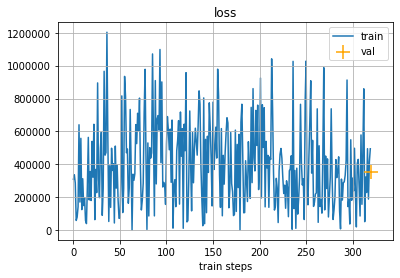





  7%|█████▍                                                                            | 1/15 [03:00<42:06, 180.45s/it]

Train loss: 396179.54582870007
Val loss: 352684.2644929886
Train metric: 52.12981720255075
Val metric: 47.412553113751684


KeyboardInterrupt: 

In [33]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, 
                                                                 criterion,
                                                                 optimizer, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 15)


In [34]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 9            |        cudaMalloc retries: 14        |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |     993 MB |    1257 MB |    5058 GB |    5057 GB |\n|       from large pool |     820 MB |    1144 MB |    4835 GB |    4834 GB |\n|       from small pool |     172 MB |     186 MB |     223 GB |     223 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |     993 MB |    1257 MB |    5058 GB |    5057 GB |\n|       from large pool |     820 MB |    1144 MB |